based on https://realpython.com/generative-adversarial-networks/

In [21]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [22]:
torch.manual_seed(111)

In [23]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Getting Data

In [24]:
# setup transformer for converting MNIST data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [25]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [26]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

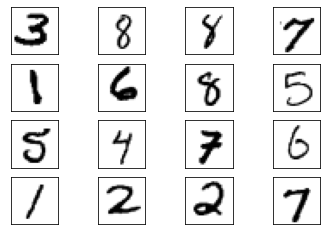

In [27]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## The Model

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        return self.model(x)


discriminator = Discriminator().to(device=device)

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(x.size(0), 1, 28, 28)


generator = Generator().to(device=device)

## Training

In [30]:
lr = 0.001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [31]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 5.867364052392077e-07
Epoch: 0 Loss G.: 19.717166900634766
Epoch: 1 Loss D.: 0.39211902022361755
Epoch: 1 Loss G.: 2.697559356689453
Epoch: 2 Loss D.: 0.6228654384613037
Epoch: 2 Loss G.: 1.282691240310669
Epoch: 3 Loss D.: 0.04979964345693588
Epoch: 3 Loss G.: 13.083114624023438
Epoch: 4 Loss D.: 0.058617137372493744
Epoch: 4 Loss G.: 7.717958450317383
Epoch: 5 Loss D.: 3.688053311634576e-07
Epoch: 5 Loss G.: 28.53446388244629
Epoch: 6 Loss D.: 5.3085472018210567e-08
Epoch: 6 Loss G.: 32.14949417114258
Epoch: 7 Loss D.: 0.0003491839743219316
Epoch: 7 Loss G.: 49.70965576171875
Epoch: 8 Loss D.: 0.000518598360940814
Epoch: 8 Loss G.: 49.742034912109375
Epoch: 9 Loss D.: 0.0
Epoch: 9 Loss G.: 61.14318084716797
Epoch: 10 Loss D.: 0.00018200254999101162
Epoch: 10 Loss G.: 64.78394317626953
Epoch: 11 Loss D.: 0.0
Epoch: 11 Loss G.: 46.91936111450195
Epoch: 12 Loss D.: 0.0
Epoch: 12 Loss G.: 84.1444320678711
Epoch: 13 Loss D.: 2.4882456273189746e-05
Epoch: 13 Loss G.: 83.9

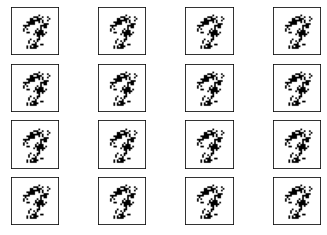

In [32]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_Samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])